Importing libraries

In [1]:
from __future__ import print_function #ccode compatibility with Python3
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models #for VGG or ResNet, transfer learning

import copy #creates shallows and deep copies of objects in Python

Mounting drive

In [158]:
from google.colab import files
uploaded=files.upload()

Saving shirt.jpg to shirt.jpg


In [136]:
uploaded=files.upload()

Saving magenta.jpg to magenta.jpg


Determining the availability of GPU and cuda.

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imsize = 512 if torch.cuda.is_available() else 128

Loading and resizing images

In [138]:
def load_image(image_path, size):
    image = Image.open(image_path)
    transform = transforms.Compose([    #resizing and conversion into PyTorch tensor
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0) #extra dimension for batch processing
    #shape of tensor needs to be [batch-size,channels,height,width]
    return image.to(device, torch.float)

def dynamic_load_images(content_path, style_path, size):
    content_img = load_image(content_path, size)
    style_img = load_image(style_path, [content_img.size(2), content_img.size(3)]) #[] extrtaxts dimensions of content image
    assert style_img.size() == content_img.size(), "Style and content images must be of the same size"
    return content_img, style_img

'''
In NST, the content and style images are passed through a pre-trained convolutional neural network
(like VGG-19) to extract feature maps at various layers. These feature maps represent the activations
of the network and are used to compute content and style losses. If the images have different sizes,
their feature maps will also have different sizes, making it impossible to directly compute losses between them.
'''

'\nIn NST, the content and style images are passed through a pre-trained convolutional neural network\n(like VGG-19) to extract feature maps at various layers. These feature maps represent the activations\nof the network and are used to compute content and style losses. If the images have different sizes,\ntheir feature maps will also have different sizes, making it impossible to directly compute losses between them.\n'

Displaying image

In [139]:
def show_image(tensor, title=None):
    image = tensor.cpu().clone() #image processing libraries expect data to be on CPU
    image = image.squeeze(0) #removes the batch-size dim from the tensor
    image = transforms.ToPILImage()(image) #Pixel values are in range 0 to 1
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

Content loss

In [140]:
# class ContentLoss(nn.Module): #compares feature map of generated image with a target feature map using MSE
#     def __init__(self, target):
#         super(ContentLoss, self).__init__()
#         self.target = target.detach() #detaches the target tensor from the computation graph
#         #avoids gradients from being computed
#         #target tensor remains constant during optimisation process

#     def forward(self, input):
#         self.loss = F.mse_loss(input, self.target)
#         return input #returns input unchanged, doesnt alter the flow of VGG

class ContentLoss(nn.Module):
    def __init__(self, target, weight=1.0):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.weight = weight

    def forward(self, input):
        self.loss = self.weight * F.mse_loss(input, self.target) #or l1_loss
        return input

Gram Matrix

In [141]:
def gram_matrix(input): #captures style of image by computing correlations between different feature maps
    batch_size, num_channels, height, width = input.size()
    features = input.view(batch_size * num_channels, height * width)
    #flattens each feature map into a singlevector
    G = torch.mm(features, features.t())#correlation matrix
    return G.div(batch_size * num_channels * height * width) #normalisation
#makes style loss more consistent

Style loss

In [142]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Loading pre-trained VGG-19 model.

In [143]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Mean and std for normalization
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Normalising

In [144]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

Extracting style and content layer

In [145]:
def get_model_and_losses(cnn, normalization_mean, normalization_std,
                         style_img, content_img,
                         content_layers=['conv_4'],
                         style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children(): #loops through layers of copied CNN
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses
#constructs a new model by inserting content and style loss layers at specified positions in a pre-trained CNN.

Dynamic loading of content and style images

In [146]:
def extend_style_image(style_img_c, border_size=50, border_color=(1, 1, 1)):
    """
    Extend the style image by adding a border around it.

    :param style_img: The original style image tensor (1, C, H, W)
    :param border_size: Size of the border to add (in pixels)
    :param border_color: Color of the border (default is white)
    :return: Extended style image tensor
    """
    _, c, h, w = style_img.shape
    new_h, new_w = h + 2*border_size, w + 2*border_size

    # Create a new tensor with the border color
    extended_img = torch.full((1, c, new_h, new_w), border_color[0], dtype=style_img.dtype, device=style_img.device)

    # Paste the original image in the center
    extended_img[:, :, border_size:border_size+h, border_size:border_size+w] = style_img

    return extended_img

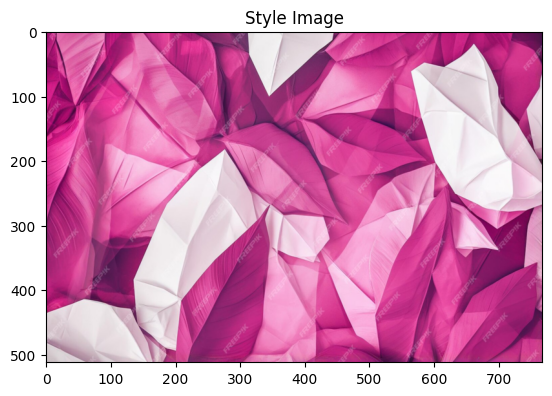

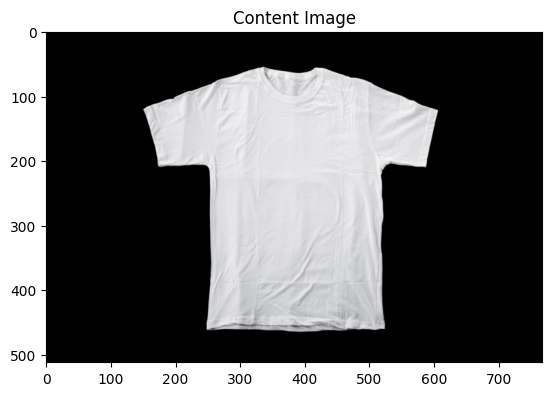

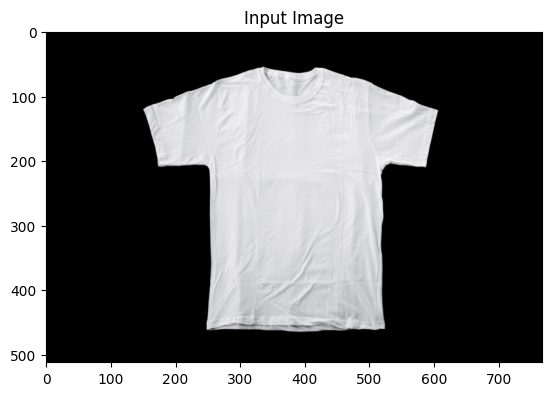

In [159]:
content_path =  'shirt.jpg' # Change as needed
style_path = "magenta.jpg"  # Change as needed
content_img, style_img = dynamic_load_images(content_path, style_path, imsize)

input_img = content_img.clone()

plt.figure()
show_image(style_img, title='Style Image')

plt.figure()
show_image(content_img, title='Content Image')

plt.figure()
show_image(input_img, title='Input Image')

Optimizer function

In [160]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()]) #cost function is smooth and the number of parameters is relatively smal
    return optimizer

Style Transfer function

In [161]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=2):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [-200]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f'Style Loss : {style_score.item()} Content Loss: {content_score.item()}')

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img


In [162]:
def enhance_silhouette(styled_image, content_image, edge_strength=1.5, blend_strength=0.7):
    device = styled_image.device  # Get the device of the input tensor

    # Convert content image to grayscale for edge detection
    content_gray = transforms.Grayscale()(content_image).squeeze()

    # Detect edges using Sobel filters
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    edges_x = torch.nn.functional.conv2d(content_gray.unsqueeze(0).unsqueeze(0), sobel_x, padding=1)
    edges_y = torch.nn.functional.conv2d(content_gray.unsqueeze(0).unsqueeze(0), sobel_y, padding=1)
    edges = torch.sqrt(edges_x**2 + edges_y**2).squeeze()

    # Normalize edge strengths
    edges = (edges - edges.min()) / (edges.max() - edges.min())

    # Create a soft mask from the edges
    mask = torch.sigmoid(10 * (edges - 0.5))  # Adjust the threshold and steepness as needed
    mask = mask.unsqueeze(0).repeat(3, 1, 1)

    # Soften the mask
    mask = transforms.GaussianBlur(3)(mask)

    # Blend the styled image with edge-enhanced original content
    enhanced = styled_image * (1 - mask * edge_strength) + content_image * mask * blend_strength

    # Final blend to preserve more of the styled image
    final = styled_image * (1 - blend_strength) + enhanced * blend_strength

    return torch.clamp(final, 0, 1)

Running style transfer function

In [ ]:
output_i = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, num_steps=300)
output=enhance_silhouette(output_i, content_img)
plt.figure()

show_image(output, title="OG Image output")
plt.ioff()
plt.show()

Building the style transfer model...
Optimizing...


<ipython-input-144-f9c14a6a0341>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-144-f9c14a6a0341>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run -150:
Style Loss : 663.4553833007812 Content Loss: 30.297687530517578
